In [106]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

# Data Generation

In [107]:
columns = ['Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Number of Employees', 'Employee Training', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
LEVELS = ["LOW", "MEDIUM", "HIGH"]
prediction_result_mapping = {0: "LOW", 1: "MEDIUM", 2: "HIGH"}

In [108]:
def generate_data(nr_entries = 1000, min_empl = 30, max_empl = 90000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in tqdm(range(0, nr_entries)):
        nr_employees = random.randint(min_empl, max_empl)
        employees_training = random.choice(LEVELS)
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = "NO" if (i % 2) == 0 else "YES"

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = invested_perc - (succ_attack / nr_attacks) + (nr_employees / max_empl) * LEVELS.index(employees_training) - (known_vulnerabilities / max_nr_vulnerabilities) + (i % 2)
        
        df.loc[i] = [invested_amount, succ_attack, failed_attack, business_value, nr_employees, employees_training, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, low_medium_boundary = 1.0, medium_high_boundary = 0.0):
  if weighted_risk >= low_medium_boundary:
      return "LOW"
  elif weighted_risk >= medium_high_boundary and weighted_risk < low_medium_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [170]:
data = generate_data(nr_entries = 100000)

100%|██████████| 100000/100000 [23:38<00:00, 70.48it/s]


In [174]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,131223,33,44,4890813,73649,HIGH,0,NO,LOW
1,963097,42,34,5043580,8084,HIGH,5,YES,MEDIUM
2,1359039,38,28,5001398,4520,LOW,5,NO,HIGH
3,691611,13,49,4965270,72774,LOW,5,YES,MEDIUM
4,376388,38,17,4934618,68223,LOW,1,NO,HIGH


In [176]:
data.describe()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
count,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,96695,50,50,76936,60502,3,10,2,3
top,656896,21,42,5024014,58685,MEDIUM,6,NO,HIGH
freq,3,2083,2120,6,8,33575,10122,50000,42203


## Data Export as .csv

In [7]:
data.to_csv('data.csv')

# Data Processing

## Categorization Step

In [177]:
start = time.time()

levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})

stop = time.time()
print(f"Categorization time: {stop - start}s")

Categorization time: 0.13099288940429688s


In [178]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,131223,33,44,4890813,73649,2,0,0,0
1,963097,42,34,5043580,8084,2,5,1,1
2,1359039,38,28,5001398,4520,0,5,0,2
3,691611,13,49,4965270,72774,0,5,1,1
4,376388,38,17,4934618,68223,0,1,0,2


## Normalization Step - using scaler

In [417]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used for Tensorflow model
normalized_data = data[features].apply(lambda x: ( (x - x.min()) / (x.max() - x.min())))
normalized_data.head()


# Used for the scikit models
#data = pd.read_csv("data.csv")
data.head()
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalited Data
X = data[features]
Y = data["Risk"]
X_normalized = scaler.transform(data[features])


# Normalized Splitted Data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
dump(scaler, SCALER_OUTPUT_PATH + 'MinMaxScaler.joblib') 

# Deep Neural Network Classifier

In [20]:
!pip3 install tensorflow
import tensorflow as tf
print(tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow
ERROR: No matching distribution found for tensorflow


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Define the training inputs
def get_train_inputs():
    x = { feature_name: tf.constant(X_train, dtype=tf.float64)}
    y = tf.constant(y_train, dtype=tf.int32)
    return x, y

# Define the test inputs
def get_test_inputs():
    x = { feature_name: tf.constant(X_test, dtype=tf.float64)}
    y = tf.constant(y_test, dtype=tf.int32)
    return x, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values, test_size=0.35)

In [ ]:
# Specify that all features have real-value data
feature_name = "risk_features"
feature_columns = [tf.feature_column.numeric_column(feature_name, 
                                                    shape=len(features))]

In [ ]:
# Build 5 layer DNN with 512, 256, 128, 64, 32 units respectively.
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[10, 5, 3],
                                            n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpecea5k00', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train

In [ ]:
classifier.train(input_fn=get_train_inputs, steps=5000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpecea5k00/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.1058244, step = 0
INFO:tensorflow:global_step/sec: 7.23013
INFO:tensorflow:loss = 0.9889312, step = 100 (13.836 sec)
INFO:tensorflow:global_step/sec: 7.27287
INFO:tensorflow:loss = 0.91795915, step = 200 (13.749 sec)
INFO:tensorflow:global_step/

## Evaluate

In [ ]:
accuracy_score = classifier.evaluate(input_fn=get_test_inputs, steps=100)["accuracy"]

print('Accuracy: {0:.2%}'.format(accuracy_score))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-02-13T22:52:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpecea5k00/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Inference Time : 2.64189s
INFO:tensorflow:Finished evaluation at 2021-02-13-22:52:27
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.92057145, average_loss = 0.22125426, global_step = 5000, loss = 0.22125421
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /

## Export

In [ ]:
feature_spec = {'risk_features': tf.io.FixedLenFeature(shape=len(features), dtype=tf.float32)}

serving_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

classifier.export_saved_model(export_dir_base='./model/export', serving_input_receiver_fn=serving_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/tmpecea5k00/model.ckpt-5000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/export/temp-1613256747/saved_model.pb


b'./model/export/1613256747'

## Prediction

### Data Preparation

In [ ]:
def get_data_for_prediction():
  return { feature_name: tf.constant(normalized_prediction_df, dtype=tf.float64)}

# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]], columns=features)

# Normalize using the initial dataframe -> bring the data for the prediction to the same scale
normalized_prediction_df = prediction_df[features]
for feature in features:
    normalized_prediction_df[feature] = normalized_prediction_df[feature].apply(lambda x: ( (x - data[feature].min()) / (data[feature].max() - data[feature].min())))

normalized_prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,0.702544,0.163265,0.591837,0.361095,0.64324,0.5,0.666667,0.0


### Result

In [ ]:
for pred in classifier.predict(input_fn=get_data_for_prediction):
  print("\n")
  print("Predicted RISK is: " + prediction_result_mapping[pred['class_ids'][0]])
  break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpecea5k00/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Predicted RISK is: MEDIUM


# Decision Tree Classifier

In [180]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

In [418]:
# Data here is not normalized
#X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)

dtree = DecisionTreeClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [ ]:
# Define the parameter ranges that should be tested on the model
dtree_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Instanciate the Grid for parameter tuning
dtree_grid = GridSearchCV(dtree, dtree_params, cv=10, scoring='accuracy', n_jobs=-1)

dtree = dtree_grid.fit(X, Y)

In [ ]:
pd.DataFrame(dtree.cv_results_).head()

In [ ]:
print(dtree.best_estimator_)
print('Best Accuracy: {0:.2%}'.format(dtree.best_score_))

## (Train - using Test-Train Split)

In [ ]:
#start = time.time()

#dtree.fit(X_train, y_train) 

#stop = time.time()
#print(f"Training time for Decision Tree Classifier: {stop - start}s")

## Evaluate

In [ ]:
# TODO
test_scores_weight_uniform = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 0]
test_scores_weight_distance = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 1]


plt.title("Mean accuracy after 10-Fold Cross Validation")
plt.plot(test_scores_weight_uniform, label='weight=uniform')
plt.plot(test_scores_weight_distance, label='weight=distance')
plt.axvline(x=28, label='Best Estimator (N=28 & weight=distance)', color='r')
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
#accuracy = dtree.score(X_test, y_test) 

#print('Accuracy: {0:.2%}'.format(accuracy))

In [ ]:
plot_confusion_matrix(dtree, X_test, y_test)  
plt.show()

## Export

In [185]:
#r = export_text(dtree_model, feature_names=features)
#print(r)

dump(dtree_model, MODEL_OUTPUT_PATH + 'Tree_classifier.joblib') 

['../src/models/Tree_classifier.joblib']

## Prediction

In [186]:
# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]], columns=features)
prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,1077113,8,29,4947796,57879,1,6,0


In [188]:
predicted_risk = dtree_model.predict(prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Support Vector Machine (SVM) classifier

In [124]:
from sklearn.svm import LinearSVC, SVC 

In [ ]:
# Linear
#svm_model = LinearSVC().fit(X_train, y_train)

## Parameter Tuning (with K-Fold Cross Validation)

In [ ]:
# Define the parameter ranges that should be tested on the model
svm_params = {
    'kernel': ["poly", "rbf", "sigmoid", "precomputed"],
    'gamma': ["scale", "auto"]
}

# Instanciate the Grid for parameter tuning
svm_grid = GridSearchCV(SVC(), svm_params, cv=10, scoring='accuracy', n_jobs=-1)

svm = svm_grid.fit(X_normalized, Y)

## (Train - using Test-Train Split)

In [125]:
# Linear
#svm_model = LinearSVC().fit(X_train, y_train)

#start = time.time()

#svm.fit(X_train_normalized, y_train)

#stop = time.time()
#print(f"Training time for polynomial SVM: {stop - start}s")

Training time for polynomial SVM: 0.24025917053222656s


## Evaluate

In [ ]:
# TODO
test_scores_weight_uniform = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 0]
test_scores_weight_distance = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 1]


plt.title("Mean accuracy after 10-Fold Cross Validation")
plt.plot(test_scores_weight_uniform, label='weight=uniform')
plt.plot(test_scores_weight_distance, label='weight=distance')
plt.axvline(x=28, label='Best Estimator (N=28 & weight=distance)', color='r')
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [147]:
#accuracy = svm_model.score(X_test_normalized, y_test) 

#print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 98.44%


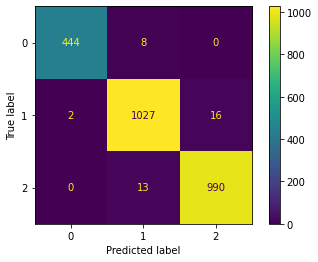

In [127]:
plot_confusion_matrix(svm_model, X_test_normalized, y_test)  
plt.show()

## Export

In [33]:
dump(svm_model, MODEL_OUTPUT_PATH + 'SVM_classifier.joblib') 

['../src/models/SVM_classifier.joblib']

## Prediction

In [128]:
predicted_risk = svm_model.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# K-nearest Neighbours Classifier

In [202]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [275]:
knn = KNeighborsClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [277]:
# Define the parameter ranges that should be tested on the model
knn_params = {
    'n_neighbors': range(1, 30),
    'weights': weights_options
}

# Instanciate the Grid for parameter tuning
knn_grid = GridSearchCV(knn, knn_params, cv=10, scoring='accuracy', n_jobs=-1)

knn = knn_grid.fit(X_normalized, Y)

In [300]:
pd.DataFrame(knn.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,4.576065,0.200660,2.837404,0.107389,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.9384,0.9414,0.9389,0.9416,0.9379,0.9450,0.9373,0.9391,0.9403,0.9363,0.93962,0.002411,55
1,4.286621,0.287884,1.759838,0.091029,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.9384,0.9414,0.9389,0.9416,0.9379,0.9450,0.9373,0.9391,0.9403,0.9363,0.93962,0.002411,55
2,3.885283,0.275575,3.210705,0.243916,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.9314,0.9355,0.9354,0.9341,0.9362,0.9402,0.9360,0.9328,0.9334,0.9301,0.93451,0.002696,58
3,3.641499,0.210027,2.134075,0.166986,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.9384,0.9414,0.9389,0.9416,0.9379,0.9450,0.9373,0.9391,0.9403,0.9363,0.93962,0.002411,55
4,3.473574,0.388592,3.195176,0.047070,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.9492,0.9541,0.9512,0.9490,0.9494,0.9556,0.9503,0.9486,0.9523,0.9465,0.95062,0.002595,53


In [409]:
print(knn.best_estimator_)
print('Best Accuracy: {0:.2%}'.format(knn.best_score_))

KNeighborsClassifier(n_neighbors=28, weights='distance')
Best Accuracy: 96.59%


## (Train - using Test-Train Split)

In [130]:
#start = time.time()

#knn.fit(X_train_normalized, y_train) 

#stop = time.time()
#print(f"Training time KNN Classifier: {stop - start}s")

Training time KNN Classifier: 0.0075609683990478516s


## Evaluate

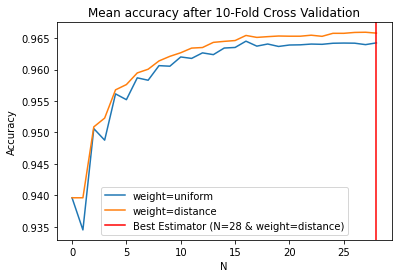

In [350]:
test_scores_weight_uniform = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 0]
test_scores_weight_distance = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 1]


plt.title("Mean accuracy after 10-Fold Cross Validation")
plt.plot(test_scores_weight_uniform, label='weight=uniform')
plt.plot(test_scores_weight_distance, label='weight=distance')
plt.axvline(x=28, label='Best Estimator (N=28 & weight=distance)', color='r')
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [317]:
#accuracy = knn.score(X_test_normalized, y_test) 
#print('Accuracy: {0:.2%}'.format(accuracy))

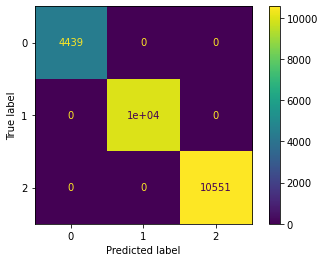

In [413]:
plot_confusion_matrix(knn, X_test_normalized, y_test)  
plt.show()

## Export

In [284]:
dump(knn, MODEL_OUTPUT_PATH + 'KNN_classifier.joblib') 

['../src/models/KNN_classifier.joblib']

## Prediction

In [414]:
predicted_risk = knn.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Multilayer Perceptron (MLP) using Backpropagation

In [324]:
from sklearn.neural_network import MLPClassifier

In [415]:
#clf = MLPClassifier(activation='tanh', solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=10000)

mlp = MLPClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [380]:
mlp_params={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(5, 2)],
'solver': ["lbfgs", "sgd", "adam"],
'activation': ["logistic", "relu", "tanh"]
}

# Instanciate the Grid for parameter tuning
mlp_grid = GridSearchCV(mlp, mlp_params, cv=10, scoring='accuracy', n_jobs=-1)

mlp = mlp_grid.fit(X_normalized, Y)

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [381]:
mlp_result = pd.DataFrame(mlp.cv_results_)

mlp_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,21.699180,0.587689,0.009680,0.003425,logistic,"(5, 2)",constant,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9436,...,0.9598,0.8970,0.9792,0.9510,0.9890,0.9749,0.9838,0.96202,0.025531,14
1,111.414816,51.885217,0.006649,0.000675,logistic,"(5, 2)",constant,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9561,...,0.9032,0.9351,0.9380,0.9354,0.4221,0.9183,0.9211,0.82703,0.202942,21
2,132.217800,12.674825,0.006818,0.001128,logistic,"(5, 2)",constant,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9941,...,0.9916,0.9923,0.9949,0.9922,0.9928,0.9920,0.9925,0.99266,0.001120,4
3,20.001387,0.771432,0.007812,0.001327,logistic,"(5, 2)",invscaling,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9594,...,0.9564,0.9435,0.9486,0.9431,0.9611,0.9737,0.9944,0.96034,0.015993,15
4,8.054568,0.679785,0.008759,0.002117,logistic,"(5, 2)",invscaling,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.4220,...,0.4220,0.4220,0.2634,0.4220,0.4221,0.4221,0.4221,0.40617,0.047590,27
5,117.366811,3.752705,0.007250,0.001123,logistic,"(5, 2)",invscaling,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9825,...,0.9928,0.9940,0.9942,0.9923,0.9854,0.9915,0.9910,0.98961,0.005170,7
6,19.424358,1.032549,0.007498,0.001701,logistic,"(5, 2)",adaptive,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9447,...,0.9236,0.9270,0.9733,0.9513,0.9672,0.9249,0.9461,0.94870,0.020087,16
7,98.175264,19.634865,0.008115,0.001902,logistic,"(5, 2)",adaptive,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9278,...,0.9557,0.9103,0.9118,0.4220,0.9229,0.8988,0.8995,0.87024,0.150341,19
8,113.984426,3.034323,0.006928,0.000567,logistic,"(5, 2)",adaptive,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.9937,...,0.9931,0.9912,0.9932,0.9918,0.9397,0.9431,0.9881,0.97908,0.020822,8
9,12.068960,7.674920,0.006581,0.001870,relu,"(5, 2)",constant,lbfgs,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.4220,...,0.9425,0.9905,0.9061,0.9981,0.9368,0.9941,0.8808,0.79148,0.244544,22


In [408]:
print(mlp.best_estimator_)
print('Best Accuracy: {0:.2%}'.format(mlp.best_score_))

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 2))
Best Accuracy: 99.56%


## (Train - Using Test-Train Split)

In [322]:
#start = time.time()

#mlp.fit(X_train_normalized, y_train)

#stop = time.time()
#print(f"Training time MLP Classifier: {stop - start}s")

## Evaluate

ValueError: x and y must have same first dimension, but have shapes (9,) and (27,)

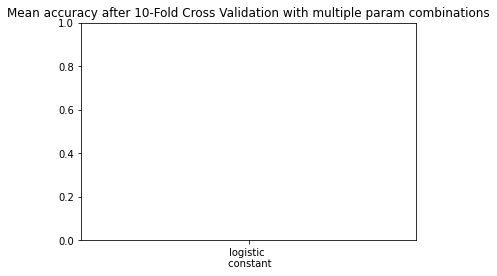

In [388]:
#TODO
test_scores = mlp.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation with multiple param combinations")
plt.plot(["logistic \n constant", "logistic \n invscaling", "logistic \n adaptive", "relu \n constant", "relu \n invscaling", "relu\n adaptive", "tanh\n constant", "tanh\n invscaling", "tanh\n adaptive"], test_scores)
plt.xticks(rotation=50)
plt.ylabel("Accuracy")
plt.show()

In [373]:
#from sklearn.model_selection import cross_val_score


#accuracy = clf.score(X_test_normalized, y_test) 

#print('Accuracy: {0:.2%}'.format(accuracy))

# lbfgs
# identity -> 90.72%
# logistic -> 98.88%
# tanh -> 99.68%
# relu -> 62.08%


# sgd
# identity -> 90.48%
# logistic -> 62.08%
# tanh -> 98.24%
# relu -> 62.08%

# adam
# identity -> 90.88%
# logistic -> 98.48%
# tanh -> 99.04%
# relu -> 98.88%

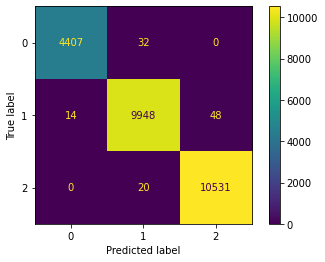

In [391]:
plot_confusion_matrix(mlp, X_test_normalized, y_test)  
plt.show()

In [ ]:
X = scaler.transform(data[features])
Y = data["Risk"]
plot_learning_curve(mlp, X, Y)

## Export

In [395]:
dump(mlp, MODEL_OUTPUT_PATH + 'MLP_back.joblib') 

['../src/models/MLP_back.joblib']

## Prediction

In [394]:
predicted_risk = mlp.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Benchmarking

In [93]:
dataset_entries = [5000, 10000, 25000, 50000, 100000]
dt_accuracy_list = []
svm_accuracy_list = []
knn_accuracy_list = []
mlp_accuracy_list = []

dt_training_times = []
svm_training_times = []
knn_training_times = []
mlp_training_times = []

In [94]:
for nr_of_entries in dataset_entries:
    data = generate_data(nr_of_entries)
    data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})
    
    X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)
    
    # Decision Tree
    dtree_model = DecisionTreeClassifier()
    start = time.time()
    dtree_model.fit(X_train, y_train) 
    stop = time.time()
    dt_training_times.append(stop - start)
    dt_accuracy_list.append(dtree_model.score(X_test, y_test))
                            
    # Scaler
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    # SVM
    svm_model = SVC(kernel='poly')
    start = time.time()
    svm_model.fit(X_train_normalized, y_train)
    stop = time.time()
    svm_training_times.append(stop - start)
    svm_accuracy_list.append(svm_model.score(X_test_normalized, y_test))
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 17)
    start = time.time()
    knn.fit(X_train_normalized, y_train) 
    stop = time.time()
    knn_training_times.append(stop - start)
    knn_accuracy_list.append(knn.score(X_test_normalized, y_test))
    
    # MLP
    clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=100000)
    start = time.time()
    clf.fit(X_train_normalized, y_train)
    stop = time.time()
    mlp_training_times.append(stop - start)
    mlp_accuracy_list.append(clf.score(X_test_normalized, y_test))
    

In [100]:
print(dataset_entries)
print("\n Accuracy:")
print("Decision Tree: " + str(dt_accuracy_list))
print(svm_accuracy_list)
print(knn_accuracy_list)
print(mlp_accuracy_list)

print("\n Training Times:")
print(dt_training_times)
print(svm_training_times)
print(knn_training_times)
print(mlp_training_times)

[5000, 10000, 25000, 50000, 100000]

 Accuracy:
Decision Tree: [0.8784, 0.9048, 0.92896, 0.93928, 0.9508]
[0.9664, 0.9772, 0.98528, 0.98728, 0.98984]
[0.9168, 0.9332, 0.9496, 0.95544, 0.96436]
[0.9888, 0.9972, 0.99824, 0.97256, 0.9992]

 Training Times:
[0.010490179061889648, 0.0204160213470459, 0.05765199661254883, 0.12712311744689941, 0.3110668659210205]
[0.06813311576843262, 0.19890880584716797, 0.8305602073669434, 3.1285979747772217, 12.188233137130737]
[0.0017361640930175781, 0.004775047302246094, 0.0270688533782959, 0.054738759994506836, 0.365800142288208]
[8.24178409576416, 11.813431978225708, 30.678292989730835, 13.996891021728516, 540.4573841094971]
